# CNN for 3D brain images
Dataset: OASIS-1
- Save the sata (disc1-12) in a folder under ./data/OASIS/ALL
- Run prepare/get_data_3d.py
- Split data into train and test by tunning prepare/oasis_make_train_test.py (requires meta data)

### Setup

In [2]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import nibabel as nib

from scipy import ndimage


/Users/kw/neuefische/alzheimer-classification/.venv/lib/python3.9/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


### Preprocessing
To process the data, we do the following:

- We rotate the volumes by 90 degrees, so the orientation is fixed
- We scale the greyscale values to be between 0 and 1.
- We resize width, height and depth to 128, 128, 64,


In [3]:

def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min0 = min(np.unique(volume))
    max0 = max(np.unique(volume))
    #[volume < min0] = min0
    #volume[volume > max0] = max0
    volume = (volume - min0) / (max0 - min0)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[2]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor,1), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [4]:
# open meta sheet for train
data_info = pd.read_csv('../data/OASIS/meta_train.csv')
normal_scan_paths = data_info.loc[data_info.CDR == 0, 'file'].to_list()
abnormal_scan_paths = data_info.loc[data_info.CDR > 0, 'file'].to_list()
print("MRI scans with normal tissue: " + str(len(normal_scan_paths)))
print("MRI scans with abnormal tissue: " + str(len(abnormal_scan_paths)))

MRI scans with normal tissue: 177
MRI scans with abnormal tissue: 54


In [6]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

## Build train and validation datasets


In [11]:
int(np.ceil(len(normal_scans) * 0.7))

124

In [13]:
# Split data in the ratio 70-30 for training and validation.
boundary_abnormal = int(np.ceil(len(abnormal_scans) * 0.7))
boundary_normal = int(np.ceil(len(normal_scans) * 0.7))
x_train = np.concatenate((abnormal_scans[:boundary_abnormal], normal_scans[:boundary_normal]), axis=0)
y_train = np.concatenate((abnormal_labels[:boundary_abnormal], normal_labels[:boundary_normal]), axis=0)
x_val = np.concatenate((abnormal_scans[boundary_abnormal:], normal_scans[boundary_normal:]), axis=0)
y_val = np.concatenate((abnormal_labels[boundary_abnormal:], normal_labels[boundary_normal:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 162 and 69.


## Data augmentation
The CT scans also augmented by rotating at random angles during training. Since the data is stored in rank-3 tensors of shape (samples, height, width, depth), we add a dimension of size 1 at axis 4 to be able to perform 3D convolutions on the data. The new shape is thus (samples, height, width, depth, 1). There are different kinds of preprocessing and augmentation techniques out there, this example shows a few simple ones to get started.

In [16]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    #volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    #volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [17]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .batch(batch_size)
    .prefetch(2)
)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-05-25 21:27:15.311560: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-25 21:27:15.312817: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Dimension of the CT scan is: (128, 128, 64, 1)


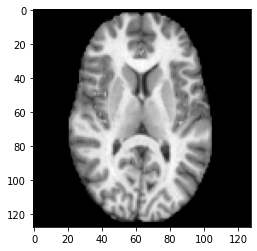

In [18]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]

images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

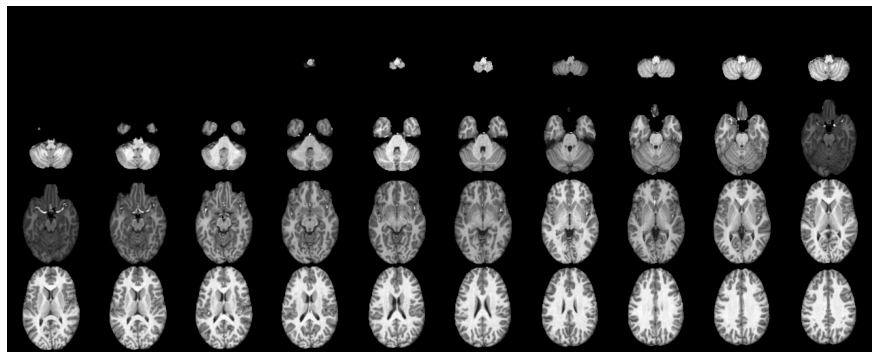

In [19]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

# CNN

what the fuck is happening here?

In [20]:
from tensorflow.keras import layers, models
#iniziating model architecture
width=128
height=128
depth=64
model = models.Sequential()
model.add(layers.Conv3D(32, (3, 3,3), activation='relu', input_shape=(width, height, depth, 1)))
model.add(layers.MaxPooling3D((2, 2,2)))
model.add(layers.Conv3D(64, (3, 3,3), activation='relu'))
model.add(layers.MaxPooling3D((2, 2,2)))
model.add(layers.Conv3D(64, (3, 3,3), activation='relu'))

: 

: 